# Workflow for Tessellating Polygons
## Climate Data Statistics sampled across a region

This notebook demonstrates how to run a tessellation algorithm on a polygonal GeoDataFrame, to get climate data values across an entire region.

Note that this Notebook presumes an input in WGS84, although plots explicitly convert to Web Mercator in order to use basemaps. 

In [110]:
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


default_plot = {
    'figsize': (15,15),
    'color': "#ffffff",
    'linewidth': 0.5,
    'edgecolor':'k'
}

default_basemap = {
    'source': cx.providers.Esri.WorldImagery, 
    'alpha': 0.2
}

display_df = lambda df: display(HTML(df.to_html()))

def tessellate_geometries(gdf, min_size_to_tesselate=0.6, grid_size=0.25):
    '''
        Tessellate geometries by overlaying a tile grid and intersecting large geometries.
        
        * `min_size_to_tesselate` is the area limit at which a geometry is split into tiles
        * `grid_size` is the tile size to use for geometries that need to be tiled
        
        Returns GeoDataFrame
    '''
    print(f"Input size, pre-tesselation: {gdf.shape[0]}")
    def tesselate_single_geom(g):
        if g.area > min_size_to_tesselate:
            xmin, ymin, xmax, ymax = g.bounds
            width, height = xmax - xmin, ymax - ymin
            grid_buff = []
            for x in np.arange(xmin, xmax, grid_size):
                for y in np.arange(ymin, ymax, grid_size):
                    grid_buff.append(
                        Polygon(
                            [
                                [x, y],
                                [x+grid_size, y],
                                [x+grid_size, y+grid_size],
                                [x          , y+grid_size],
                                [x          , y],
                            ]
                        ))
            intersections = [g.intersection(grid) for grid in grid_buff]
            return [i for i in intersections if not i.is_empty]

        return [g]
    
       
    tess_geoms = pd.concat([
        gdf,
        gdf.geometry.apply(tesselate_single_geom).rename('tesselated_geoms')
    ], axis=1).explode('tesselated_geoms')
    tess_geoms.geometry = tess_geoms.tesselated_geoms
    tess_geoms.drop('tesselated_geoms', inplace=True, axis=1)
    print(f"Output size, post-tesselation: {tess_geoms.shape[0]}")
    return tess_geoms


def plot_geometries(gdf, plot_params=default_plot, basemap_params=default_basemap):
    ax = gdf.to_crs(epsg=3857).plot(
        **{**default_plot, **plot_params}
    )
    cx.add_basemap(
        ax, 
        **{**default_basemap, **basemap_params}
    )

### Load National Forests data
This is volume mounted in at container run-time

In [5]:
national_forests = gpd.read_file('/app/data/national_forests.json')

Sample plot National Forests

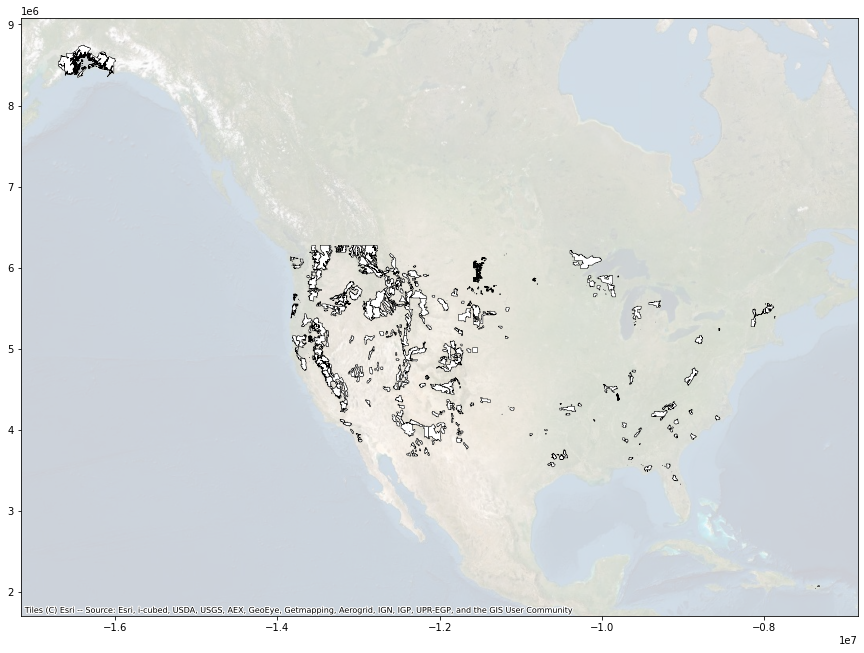

In [94]:
plot_geometries(national_forests)

Investigate a few of the larger national forests

In [98]:
display_df(national_forests.sort_values("SHAPE_AREA", ascending=False).drop("geometry", axis=1).iloc[0:5])


,ADMINFORES,REGION,FORESTNUMB,FORESTORGC,FORESTNAME,GIS_ACRES,SHAPE_AREA,SHAPE_LEN
2,99100400010343,10,04,1004,Chugach National Forest,6244703.986,4.146458,140.650701
18,99041700010343,04,17,0417,Humboldt-Toiyabe National Forest,6704118.270,2.833239,46.757032
69,99020600010343,02,06,0206,Medicine Bow-Routt National Forest,4592830.133,2.024215,28.015140
25,99041300010343,04,13,0413,Salmon-Challis National Forest,4396289.597,2.018913,24.663329
65,99090900010343,09,09,0909,Superior National Forest,3887905.471,1.892104,14.485443


### Plot Salmon-Challis National Forest, ID
Note that Salmon-Challis, like many parks, has multiple distinct park boundaries (aka it is a MultiPolygon).  The output of tessellation will have multiple rows, but each row can still potentially be a geometry if the tile overlaps more than one exterior ring (sub-Polygon).

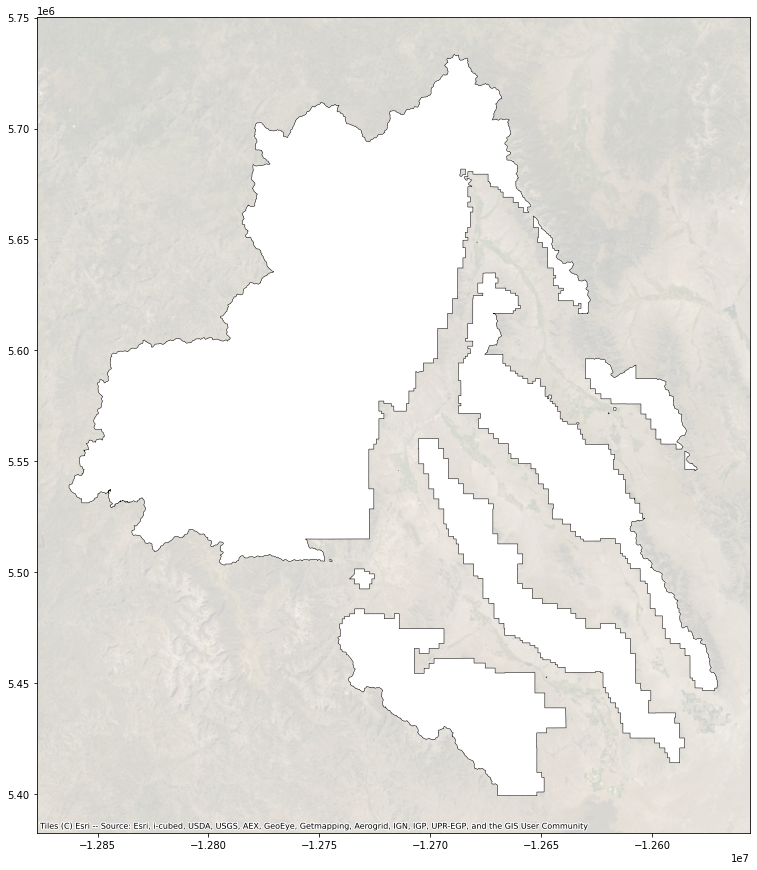

In [100]:
PARK_NAME='Salmon-Challis National Forest'
parks_to_plot = national_forests[national_forests['FORESTNAME'] == PARK_NAME]
plot_geometries(parks_to_plot)


In [101]:
parks_to_plot_tessellated = tessellate_geometries(parks_to_plot)

Input size, pre-tesselation: 1
Output size, post-tesselation: 70


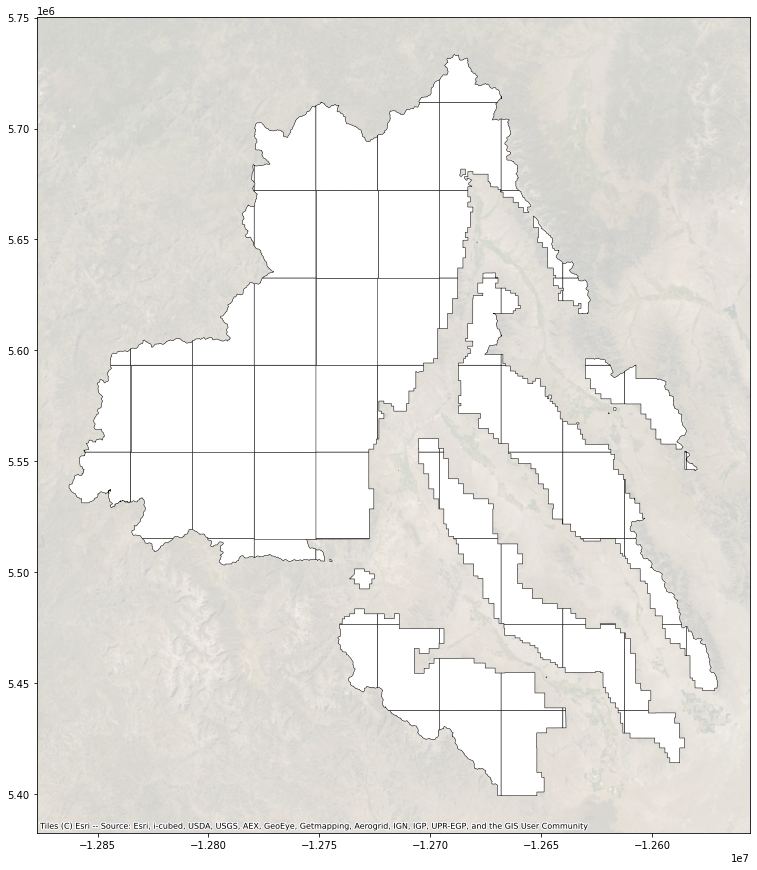

In [102]:
plot_geometries(parks_to_plot_tessellated)

With the above, a region has been tiled into many sub-regions, which can each be independently be assessed for hazard risk.

### Work with the Sust Global API to upload Tessellated Regions

Using the above data, let's create a portfolio for tessellated assets, and run it through the Sust Global API to generate physical risk exposure.

In [80]:
import requests, json
from shapely.geometry import shape
import os

API_KEY = os.getenv("SUST_API_KEY")
PROJECT = os.getenv("SUST_PROJECT")

PORTFOLIO = "tessellated_salmon_challis"

endpoints = {
    "portfolio": f"https://explorer.sustglobal.io/api/portfolios/?api_key={API_KEY}&project={PROJECT}",
    "asset_import": f"https://explorer.sustglobal.io/api/portfolios/{PORTFOLIO}/assets/import/?api_key={API_KEY}&project={PROJECT}",
    "assets"    : f"https://explorer.sustglobal.io/api/portfolios/{PORTFOLIO}/assets?api_key={API_KEY}&project={PROJECT}&rows=200",
    "summary"   : f"https://explorer.sustglobal.io/api/portfolios/{PORTFOLIO}/datasets/physical/summary?api_key={API_KEY}&project={PROJECT}&rows=200",
    "physical"  : f"https://explorer.sustglobal.io/api/portfolios/{PORTFOLIO}/datasets/physical/items?api_key={API_KEY}&project={PROJECT}&rows=200"
}


def check_status(portfolio_name):
    '''Check the status of a portfolio'''
    status = requests.get(endpoints["portfolio"])
    print([i for i in json.loads(status.content) if i['portfolio_name'] == portfolio_name])

    
def get_endpoint_as_df(endpoint_id, params={}, fetch_args={"print_pages": False}):
    '''
        Fetch an endpoint (natively JSON) as a Pandas DataFrame,
        with some endpoint-specific logic.
    '''
    def fetch_with_pagination(endpoint_id, **kwargs):
        page = 1
        buff = []
        if endpoint_id == "portfolios":
            return pd.DataFrame(requests.get(f'{endpoints[endpoint_id]}').json())
        while True:
            response = requests.get(f'{endpoints[endpoint_id]}&page={page}', params=params).json()
            if len(response) > 0:
                if kwargs["print_pages"]:
                    print(page)
                buff = buff + response
                page += 1
            else:
                return pd.DataFrame(buff)
            
    res_df = fetch_with_pagination(endpoint_id, **fetch_args)
    if endpoint_id == "assets":
        if "geometry" in res_df.columns: # Polygons
            return gpd.GeoDataFrame(res_df.copy().drop("geometry", axis=1), geometry=res_df.geometry.apply(shape), crs="EPSG:4326")
        else: # Points
            return gpd.GeoDataFrame(res_df.copy(), geometry=gpd.points_from_xy(res_df.lng, res_df.lat), crs="EPSG:4326")
    elif endpoint_id == "physical":
        return pd.concat([
            res_df.drop('risk_exposure', axis=1),
            pd.DataFrame(list(res_df.risk_exposure))
        ], axis=1)
    else:
        return res_df
    
    
    
def map_risk_summary_json_to_single_hazard(summary_series, hazard):
    '''
        Get a single risk summary column from a summary JSON
    '''
    return pd.concat([
        summary_series.drop("risk_summaries", axis=1), 
        pd.DataFrame(list(summary_series.risk_summaries.apply(lambda s: [i for i in s if i["hazard"] == hazard][0])))
    ], axis=1)


**Create a Portfolio that will contain the tessellated polygonal data**

In [ ]:
x = requests.post(endpoints["portfolio"], json = {"portfolio_name": PORTFOLIO})
x

Check the status of the created portfolio

In [63]:
check_status(PORTFOLIO)

[{'portfolio_id': '49cf2bdf5215937b', 'portfolio_name': 'tessellated_salmon_challis', 'created_at': '2022-08-16T00:15:26Z', 'updated_at': '2022-08-16T00:34:41Z', 'status': 'Waiting on risk data generation'}]


**Import polygons into the created portfolio**

In [66]:
status = requests.post(endpoints["asset_import"], files={
    'asset': ('tessellated_salmon_challis.json', parks_to_plot_tessellated.to_json())
})
print(status)

<Response [202]>


In [68]:
check_status(PORTFOLIO)

[{'portfolio_id': '49cf2bdf5215937b', 'portfolio_name': 'tessellated_salmon_challis', 'created_at': '2022-08-16T00:15:26Z', 'updated_at': '2022-08-16T01:32:41Z', 'status': 'Risk data available'}]


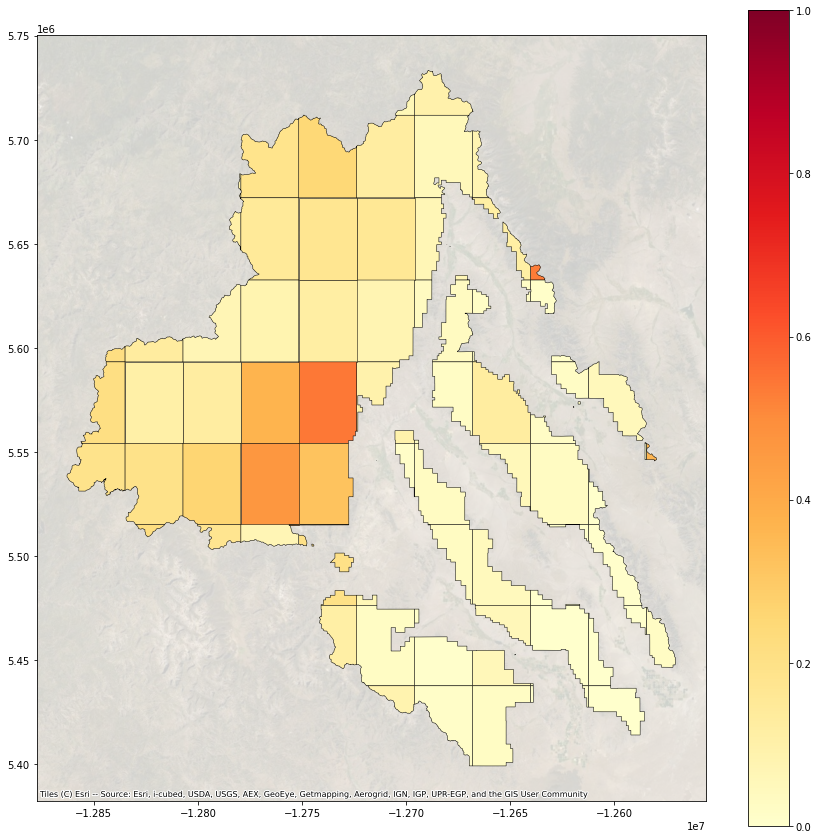

In [114]:
# Get Assets
assets = get_endpoint_as_df("assets")

# Get Hazard Summary data and merge with assets
summary = get_endpoint_as_df("summary", params={'window': 15, 'scenario': 'ssp585'})
wildfire_summary = map_risk_summary_json_to_single_hazard(summary, "wildfire")
assets_combined_summaries = assets.merge(wildfire_summary, on="portfolio_index")

plot_geometries(
    assets_combined_summaries, 
    plot_params={
        'color': None,
        'column':"risk_score",
        'cmap':"YlOrRd",
        'legend': True
    }
)

In [115]:
display_df(assets_combined_summaries.sort_values("risk_score", ascending=False).drop("geometry", axis=1).iloc[0:5])

,portfolio_name_x,portfolio_index,entity_id_x,entity_name_x,labels,portfolio_name_y,entity_name_y,entity_id_y,window,window_start_year,scenario,hazard,risk_class,risk_score
43,tessellated_salmon_challis,26,,,{},tessellated_salmon_challis,,,15,2022,ssp585,wildfire,HIGH,1.000000
47,tessellated_salmon_challis,22,,,{},tessellated_salmon_challis,,,15,2022,ssp585,wildfire,HIGH,0.541095
9,tessellated_salmon_challis,60,,,{},tessellated_salmon_challis,,,15,2022,ssp585,wildfire,HIGH,0.534705
55,tessellated_salmon_challis,14,,,{},tessellated_salmon_challis,,,15,2022,ssp585,wildfire,HIGH,0.466986
54,tessellated_salmon_challis,15,,,{},tessellated_salmon_challis,,,15,2022,ssp585,wildfire,HIGH,0.370012
